In [1]:
import numpy as np  # NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt  # For plotting
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist

In [2]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import person
from citychef import tree
from citychef import choice

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

### Facilities
First we generate the location of various facilities, including households where the populations will live and activity locations such work places, leisure, education, shopping and health facilities.

#### Method
1. define seed bounding box
2. uniformly sample 'centres' within bounding box
3. poisson sample number of facilities of each type around each centre
4. gaussian sample locations of facilities around each centre

In [4]:
bbox = np.array([[0,0],[100,100]])  # min x, min y, max x, max y (kms)

In [5]:
centres = spatial.Centres(bbox, density = 0.002)
centres

15 centres

(0.6379358072115906, 103.58557066231715, -0.652593197413402, 97.70247688904558)

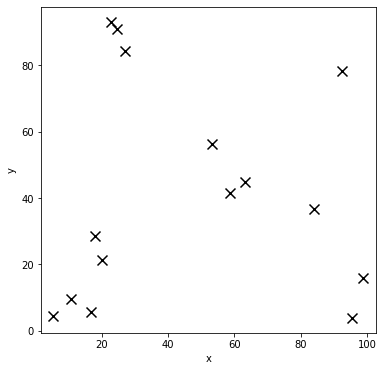

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(centres.locs[:, 0], centres.locs[:, 1], alpha=1, marker='x', s=100, c='black')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [7]:
hhs = spatial.Clusters(centres, size=10000, sigma=10)
hhs

9951 units, 15 centres

In [8]:
work = spatial.Clusters(centres, size=1000, sigma=5)
work

998 units, 15 centres

In [9]:
leisure = spatial.Clusters(centres, size=1000, sigma=8)
leisure

1004 units, 15 centres

In [10]:
education = spatial.Clusters(centres, size=500, sigma=8)
education

467 units, 15 centres

In [11]:
health = spatial.Clusters(centres, size=100, sigma=8)
health

92 units, 15 centres

In [12]:
shopping = spatial.Clusters(centres, size=1000, sigma=5)
shopping

1007 units, 15 centres

In [13]:
facilities = [hhs, work, leisure, education, health, shopping]
new_bbox = spatial.collect_bbox(facilities)

(-39.07654405506447,
 138.41333127834952,
 -38.35217140107689,
 134.05199594985982)

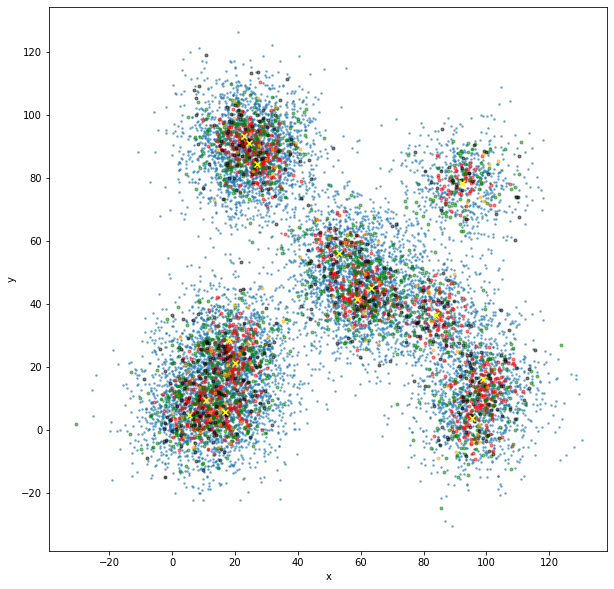

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(hhs.x, hhs.y, alpha=0.5, marker='.', s=10)
ax.scatter(work.x, work.y, alpha=0.5, marker='.', c='r')
ax.scatter(leisure.x, leisure.y, alpha=0.5, marker='.', c='g')
ax.scatter(education.x, education.y, alpha=0.5, marker='.', c='black')
ax.scatter(health.x, health.y, alpha=0.5, marker='.', c='orange')
ax.scatter(centres.x, centres.y, alpha=1, marker='x', c='yellow')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

### Road Network

We build a road network for car travel. We use a quad tree to define the density of the network so that accessibility is likely better where household density is higher. The connectivity of the resulting networks is based on parent - child relationships within the quad tree. This results in poor connectivity between neighbouring quad grids if they are removed by several generations, ie their shared parent is distant.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time.

#### Method

1. Build a grid tree with maximum household density of N.
2. Build a network of roads from the grid tree

(-41.35806746942865,
 141.15414485058614,
 -41.04433676946693,
 136.74416131824987)

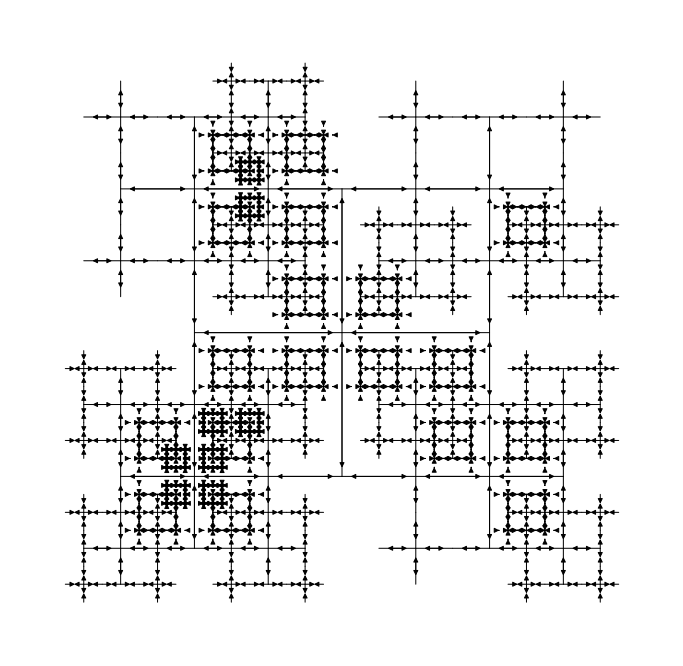

In [47]:
# add index to locs so we can keep track of them
data = np.zeros((hhs.size, 3))
data[:,0] = range(hhs.size)
data[:,1:] = hhs.locs

car_grid = tree.RegularBlock(bbox=new_bbox, data=data, max_points=200)

car_network = graph.TreeNetwork(car_grid)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

nx.draw_networkx_edges(
    car_network.g, pos=car_network.pos, ax=ax, edge_color='black', alpha=1, arrows=True, width=1
)

fig.patch.set_visible(False)
ax.axis('off')

### Bus Network

We build a bus network for public transit travel on the road network. A route generation algorithm attempts to build viable routes by making weighted random walks across the road network from seed locations.

The random walks are seeded based on a weighted sample from the road network vertices. Where the vertices are weighted by household density at each vertices. From each seed location the weighted random walk traverses the possible network based on weighted random choice of each possible step. Where weights are based on the household density of the possible choices, the straightness of the resulting graph and the number of times the edges have already been traversed by a route. Routes cannot repeat the previous edge so that the traversal ends at dead ends in the road network or when a maximum number of stops is reached.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time as per the underlying road network. For simplicity, no consideration is made of a schedule or interchange times.

#### Method

1. Build an array of houshold density for each vertices of the road network graph
2. Sample number of required routes based on population and a poisson distribution
3. Generate route
4. Add generated routes that meet minimum requirements for stops and length
5. Combine routes to form total bus network graph

In [48]:
car_node_hh_density = spatial.density(car_network.locs, hhs)

num_bus_routes = np.random.poisson(hhs.size/200)
bus_routes = []
while len(bus_routes) <= num_bus_routes:
    route = graph.PTRoute(
        network=car_network.g,
        node_weights=car_node_hh_density,
        node_lookup=car_network.node_index_lookup,
        existing_routes=bus_routes,
        max_length=30,
        straightness_weight=2
    )
    if route.stops >= 10 and route.length >= 10:
        bus_routes.append(route)


In [49]:
total_bus_graph = nx.compose_all([r.g for r in bus_routes])

(-35.14567095464032, 132.95735487282502, -35.0472013248771, 128.76211166124702)

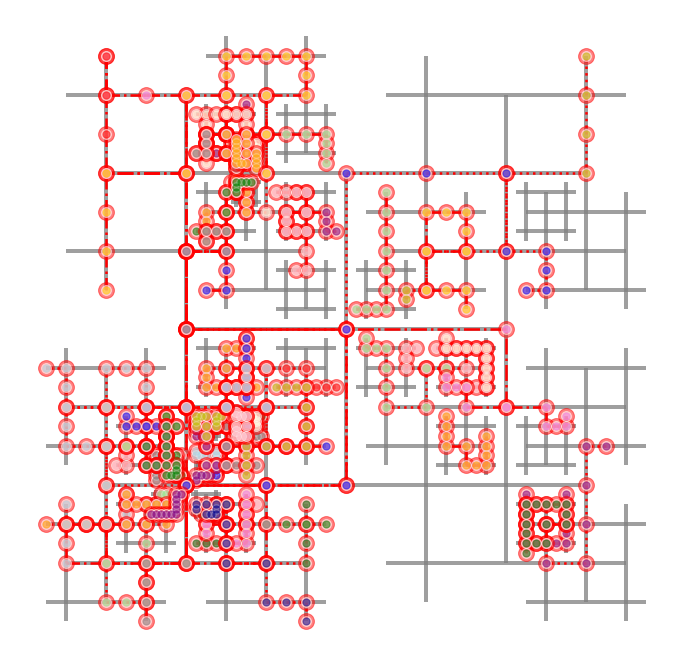

In [50]:
def gen_colour():
    cols = [
        'pink',
        'red',
        'lightyellow',
        'y',
        'orange',
        'lightblue',
        'b',
        'darkblue',
        'lightgreen',
        'g',
        'darkgreen',
        'purple',
        'violet',
        'grey',
        'gold'
    ]
    return np.random.choice(cols)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

nx.draw_networkx_edges(car_network.g, pos=car_network.pos, ax=ax, edge_color='grey', alpha=.5, arrows=False, width=4)
    
for r in bus_routes:
    g = r.g
    pos = {k: v['pos'] for k, v in g.nodes.items()}
    c2 = gen_colour()
    style = np.random.choice(['dotted','dashdot'])
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='r', style=style, node_size = 250, alpha=.5)
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='white', style=style, node_size = 100, alpha=.5)
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color=c2, style=style, node_size = 50, alpha=.5)
    nx.draw_networkx_edges(g, pos=pos, ax=ax, style=style, edge_color='red', arrows=False, width=2.5)
    
fig.patch.set_visible(False)
ax.axis('off')

### Bus Network

We build a rail network for public transit travel not restricted by the road network. As per the bus network a route generation algorithm attempts to build viable routes by weighted random walks. Unlike the bus network we build a new graph for all potential rail connections. This graph connects all road network junctions (not dead ends) based on Delaunay triangulation.

The random walks are seeded and traverse as per the bus network.

Edges are assigned a distance, a speed (based on distance) and a resulting traversal time. For simplicity, no consideration is made of a schedule or interchange times.

#### Method

1. Build an array of houshold density for junction vertices of the road network graph
2. Sample number of required routes based on population and a poisson distribution
3. Generate routes
4. Add generated routes that meet minimum requirements for stops and length
5. Combine routes to form total rail network graph

In [52]:
# train 
junctions = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[-6:] == 'centre'])

rail_network = graph.DelaunayNetwork(junctions)

rail_network_hh_density = spatial.density(rail_network.locs, hhs)

num_train_routes = np.random.poisson(int(hhs.size/4000))
train_routes = []
while len(train_routes) <= num_train_routes:
    route = graph.PTRoute(
        network=rail_network.g,
        node_weights=rail_network_hh_density**3,
        node_lookup=rail_network.node_index_lookup,
        existing_routes=train_routes,
        max_length=10,
        straightness_weight=50
    )
    if route.stops >= 6 and route.length >= 10:
        train_routes.append(route)
        
train_routes

In [53]:
total_train_graph = nx.compose_all([r.g for r in train_routes])

(-33.06205781851889,
 132.85813519967638,
 -32.96304140184344,
 128.66286595062638)

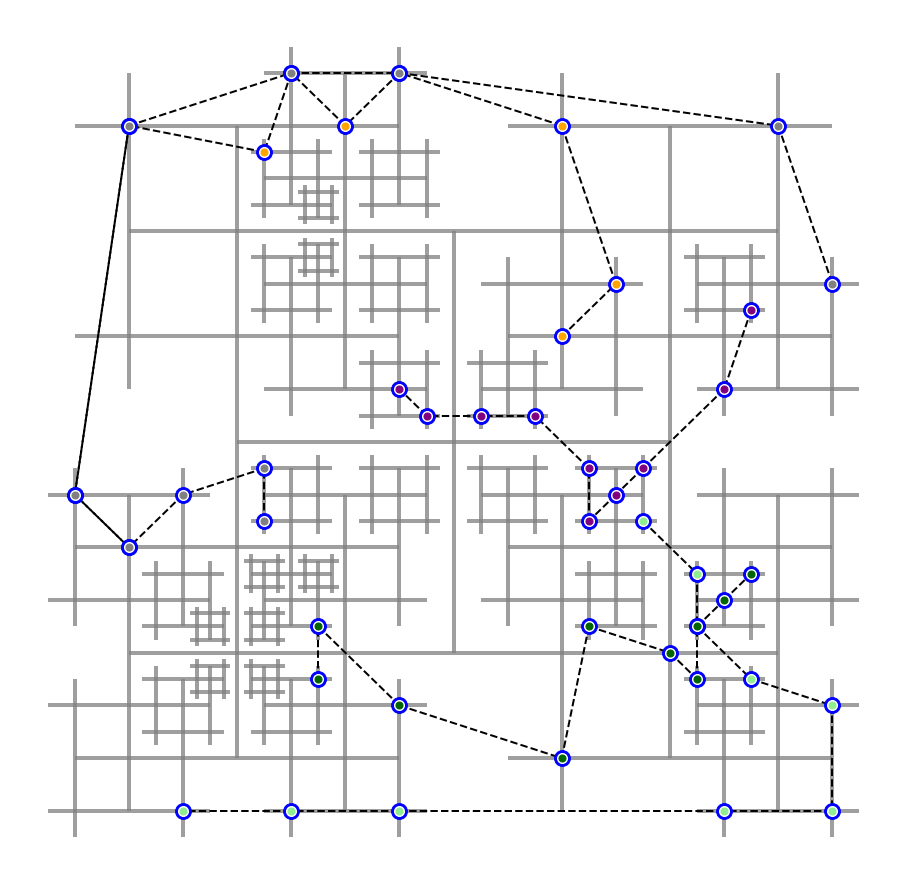

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

nx.draw_networkx_edges(car_network.g, pos=car_network.pos, ax=ax, edge_color='grey', alpha=.5, arrows=False, width=4)
    
# for r in bus_routes:
#     g = r.g
#     pos = {k: v['pos'] for k, v in g.nodes.items()}
#     c2 = gen_colour()
#     style = np.random.choice(['dotted','dashdot'])
#     nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='r', style=style, node_size = 250, alpha=.5)
#     nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='white', style=style, node_size = 100, alpha=.5)
#     nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color=c2, style=style, node_size = 50, alpha=.5)
#     nx.draw_networkx_edges(g, pos=pos, ax=ax, style=style, edge_color='red', arrows=False, width=2.5)
    
for r in train_routes:
    g = r.g
    pos = {k: v['pos'] for k, v in g.nodes.items()}
    c2 = gen_colour()
    style = np.random.choice(['dashed'])
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='b', style=style, node_size = 250, alpha=1)
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color='white', style=style, node_size = 100, alpha=1)
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color=c2, style=style, node_size = 50, alpha=1)
    nx.draw_networkx_edges(g, pos=pos, ax=ax, style=style, edge_color='black', arrows=False, width=2)
    
fig.patch.set_visible(False)
ax.axis('off')

### Infrastructure

We now have spatial and graph representations of our city facilities and infrastructure.

(-38.834635287641056,
 138.4010696845803,
 -38.35137152400132,
 134.05119607278428)

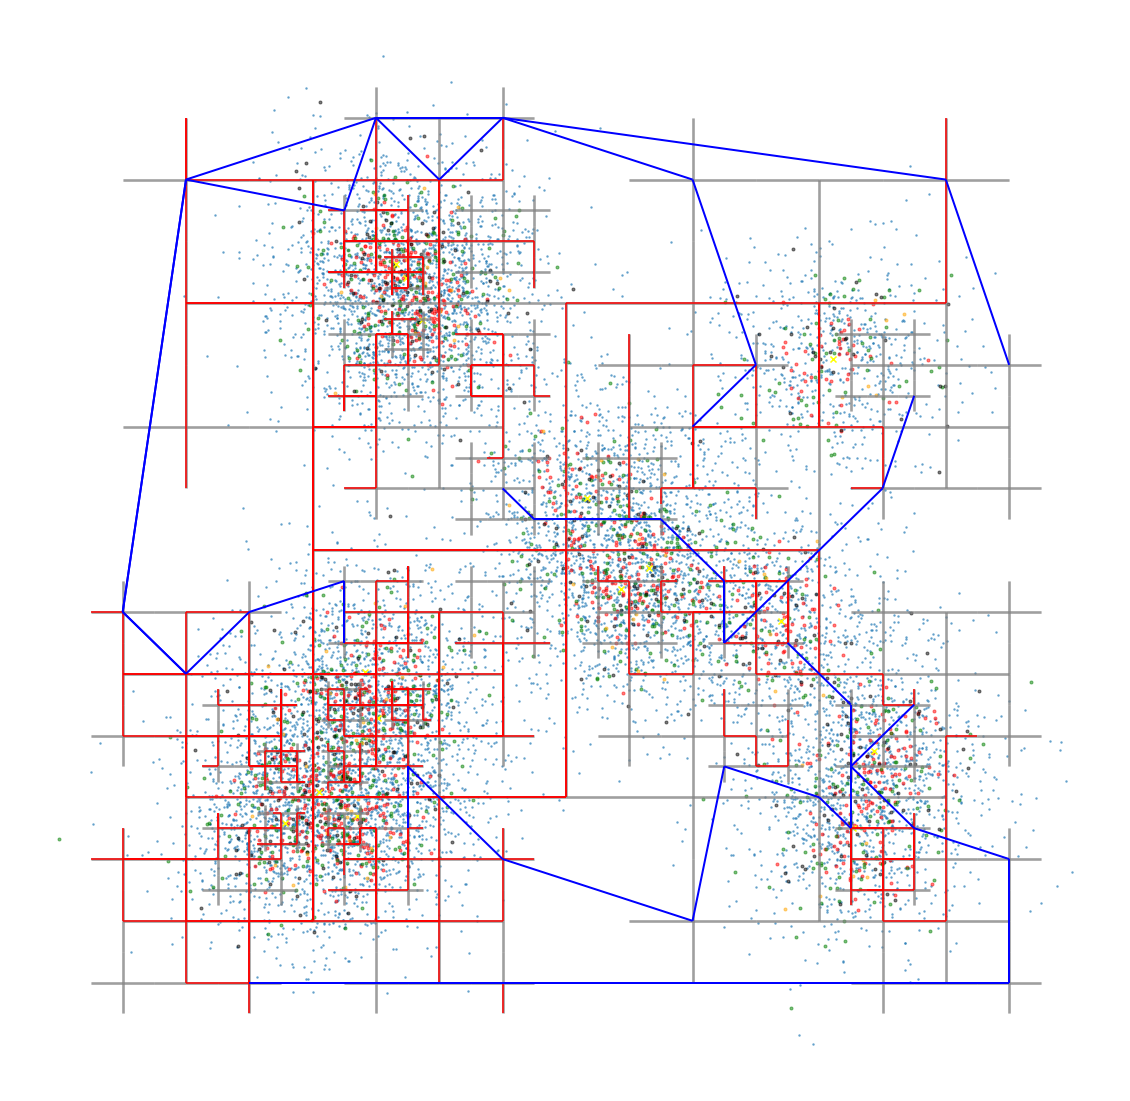

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.scatter(hhs.x, hhs.y, alpha=0.5, marker='.', s=10)
ax.scatter(work.x, work.y, alpha=0.5, marker='.', c='r')
ax.scatter(leisure.x, leisure.y, alpha=0.5, marker='.', c='g')
ax.scatter(education.x, education.y, alpha=0.5, marker='.', c='black')
ax.scatter(health.x, health.y, alpha=0.5, marker='.', c='orange')
ax.scatter(centres.x, centres.y, alpha=1, marker='x', c='yellow')

nx.draw_networkx_edges(car_network.g, pos=car_network.pos, ax=ax, edge_color='grey', alpha=.5, arrows=False, width=2.5)
    
for r in bus_routes:
    g = r.g
    pos = {k: v['pos'] for k, v in g.nodes.items()}
    c2 = gen_colour()
    style = np.random.choice(['solid'])
    nx.draw_networkx_edges(g, pos=pos, ax=ax, style=style, edge_color='red', arrows=False, width=1.5)
    
for r in train_routes:
    g = r.g
    pos = {k: v['pos'] for k, v in g.nodes.items()}
    c2 = gen_colour()
    style = np.random.choice(['solid'])
    nx.draw_networkx_edges(g, pos=pos, ax=ax, style=style, edge_color='blue', arrows=False, width=2)
    
fig.patch.set_visible(False)
ax.axis('off')
plt.axis('equal')

In [83]:
plt.savefig('city.png')

<Figure size 432x288 with 0 Axes>

### Population Features

Features for our population will be generated at two primary levels - household and individual. Additional features will be generated at both levels but be considered hidden, ie part of the generative process only.

Features will be either categorical or numeric.

We will start with household features before expanding these to the individual level based on occupants of each household.

In [56]:
hh_df = pd.DataFrame(range(hhs.size), columns=['hh_index'])
hh_hidden_df = pd.DataFrame(range(hhs.size), columns=['hh_index'])

### Household Zones

Generate zone geometries and assign households zone IDs.

#### Method

1. Assign index to household locations
2. Build an irregular (randomly) quad tree structure with a maximum grid density of N households
3. Assign zone to households

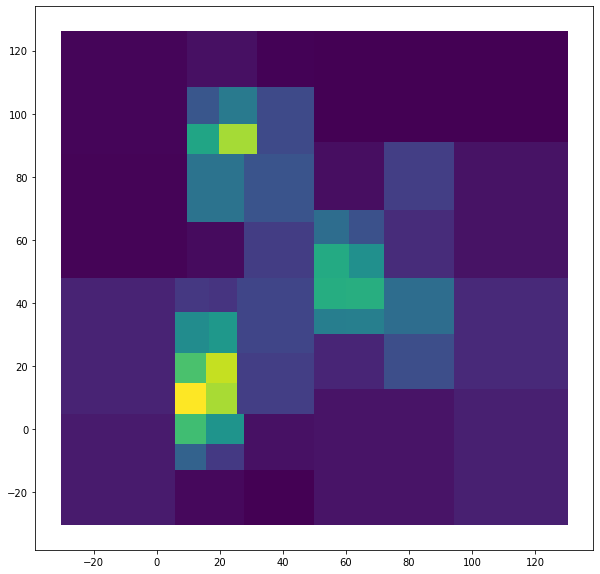

In [57]:
# add index to locs so we can keep track of them
data = np.zeros((hhs.size, 3))
data[:,0] = range(hhs.size)
data[:,1:] = hhs.locs

zones_grid = tree.IrregularBlock(bbox=new_bbox, data=data, max_points=500)
hh_grid_ids, block_gdf, centroids = tree.build_zones(zones_grid)

block_gdf.plot(column='density', figsize=(10,10))

In [58]:
hh_df['zone_id'] = hh_grid_ids

### Household Hidden Features

Household hidden features will primarilly be based on spatial patterns such as facility density (based on radius R), and facility distances to nearest N facilities.

In [59]:
def minmax(array, axis=0):
    if len(array.shape) > 1:
        return (array - array.min(axis=axis)) / (array.max(axis=axis) - array.min(axis=axis))
    else:
        return (array - min(array)) / (max(array) - min(array))

In [60]:
hh_dist_to_centre = hhs.dist_to_centres()
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

hh_hidden_df['density_mm'] = spatial.density(hhs, hhs)
hh_hidden_df['dist_closest_centre_mm'] = spatial.distances_to_closest(hhs, centres, 1)
hh_hidden_df['dist_closest_centres_mm'] = spatial.distances_to_closest(hhs, centres, 3)
hh_hidden_df['density_work_places_mm'] = spatial.density(hhs, work, 5)
hh_hidden_df['density_leisure_mm'] = spatial.density(hhs, leisure, 5)
hh_hidden_df['dist_closest_schools_mm'] = spatial.distances_to_closest(hhs, education, 2)
hh_hidden_df['dist_closest_health_mm'] = spatial.density(hhs, health, 1)

hh_locs_mm = minmax(hhs.locs)
hh_centre_ids_mm = minmax(hhs.ids)

hh_hidden_df['hidden'] = hh.gen_hidden(hh_locs_mm[:,0], hh_locs_mm[:,1], hh_hidden_df['density_mm'])

In [61]:
hh_hidden_df.head()

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden
0,0,0.157895,0.189176,0.088567,0.37500,0.600000,0.101065,0.0,5
1,1,0.421053,0.149769,0.121284,0.40625,0.342857,0.033040,0.0,5
2,2,0.000000,0.468791,0.359684,0.00000,0.114286,0.299566,0.0,5
3,3,0.157895,0.340149,0.219438,0.00000,0.285714,0.038860,0.0,1
4,4,0.368421,0.048364,0.061208,0.56250,0.571429,0.076052,0.0,3


### Household Features

Household features are generated based on hidden features and previously generated features. All generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [62]:
hh_df['hh_count'] = hh.gen_hh_count(
    hh_hidden_df['hidden'], 
    hh_hidden_df['density_mm']
)

hh_df['hh_children'] = hh.gen_num_children(
    hh_df['hh_count'],
    hh_hidden_df['hidden'],
    hh_hidden_df['dist_closest_schools_mm'],
    hh_hidden_df['density_leisure_mm']
)

hh_hidden_df['age_group'] = hh.gen_age_group(
    hh_df['hh_children'],
    hh_hidden_df['hidden'],
    hh_hidden_df['density_mm']
)

hh_df['hh_people_in_work'] = hh.get_people_in_work(
    hh_hidden_df['age_group'],
    hh_hidden_df['hidden'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_mm']
)

hh_df['hh_in_work'] = hh.get_in_work(
    hh_df['hh_people_in_work']
)

hh_df['hh_income'] = hh.get_income(
    hh_df['hh_in_work'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_work_places_mm'],
    hh_hidden_df['density_mm']
)

hh_income_mm = minmax(hh_df['hh_income'])

hh_df['hh_cars'] = hh.get_cars(
    hh_hidden_df['hidden'],
    hh_income_mm,
    hh_hidden_df['density_mm'],
    hh_df['hh_count'],
    hh_df['hh_children']
)

### Individual Features

Individuals features are generated based on their household hidden features and previously generated features. As per for households, all generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [63]:
# hh features
hh_counts = hh_df['hh_count'].to_numpy()
agent_hh_array = np.repeat(hh_df.to_numpy(), hh_counts, axis=0)
person_df = pd.DataFrame(agent_hh_array)
person_df.columns = hh_df.columns
person_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

#hidden vectors
agent_hidden_array = np.repeat(hh_hidden_df.to_numpy(), hh_counts, axis=0)
person_hidden_df = pd.DataFrame(agent_hidden_array)
person_hidden_df.columns = hh_hidden_df.columns
person_hidden_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

In [64]:
person_df['adult'] = person.get_is_adult(
    person_df['p_hh_index'],
    person_df['hh_count'],
    person_df['hh_children']
)

person_df['gender'] = person.get_gender(
    person_df['p_hh_index'], 
    person_df['adult'],
    person_df['hh_children'],
    person_hidden_df['hidden']
)

person_df['age'] = person.get_age(
    person_hidden_df['hidden'],
    person_hidden_df['age_group'],
    person_df['adult']
)

person_df['employment'] = person.employment(
    person_df['adult'],
    person_df['hh_people_in_work'],
    person_df['p_hh_index'],
    person_df['age'],
    person_hidden_df['hidden'],
    person_hidden_df['dist_closest_schools_mm'],
    person_hidden_df['density_work_places_mm'],
    person_df['hh_income'],
    person_hidden_df['density_mm'],
)

person_df['occupation'] = person.occupation(
    person_df['employment'],
    person_df['age'],
    minmax(person_df['hh_income']),
)

person_df.head(10)

,hh_index,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation
0,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,0,1,1,37.0,3,1
1,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,1,1,2,37.0,3,1
2,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,2,0,0,7.0,2,0
3,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,0,1,0,25.0,3,1
4,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,1,1,0,28.0,3,1
5,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,2,1,0,26.0,3,1
6,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,3,0,0,8.0,2,0
7,2.0,52.0,2.0,0.0,0.0,0.0,17000.0,0.0,0,1,0,74.0,0,0
8,2.0,52.0,2.0,0.0,0.0,0.0,17000.0,0.0,1,1,0,75.0,0,0
9,3.0,15.0,4.0,1.0,2.0,1.0,65000.0,1.0,0,1,1,30.0,3,1


In [65]:
person_hidden_df.head()

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden,age_group,p_hh_index
0,0.0,0.157895,0.189176,0.088567,0.37500,0.600000,0.101065,0.0,5.0,34.0,0
1,0.0,0.157895,0.189176,0.088567,0.37500,0.600000,0.101065,0.0,5.0,34.0,1
2,0.0,0.157895,0.189176,0.088567,0.37500,0.600000,0.101065,0.0,5.0,34.0,2
3,1.0,0.421053,0.149769,0.121284,0.40625,0.342857,0.033040,0.0,5.0,25.0,0
4,1.0,0.421053,0.149769,0.121284,0.40625,0.342857,0.033040,0.0,5.0,25.0,1


### Activity Choice

A simple activity plan is generated based on individual features. This plan consists of a single activity at a given facility location.

#### Method
1. Activity type choice is made based on household and individual features. This can include staying at home.
2. Facilities for each activity type are weighted by their desirability (based on density and distance).
3. Agents randomly choose a facility based on this weighting and on their individual features.

In [66]:
# Main activity choice
person_df['main_activity'] = choice.main_activity_choice(
    person_df['employment'],
    person_hidden_df['density_work_places_mm'],
    person_df['occupation'],
    person_hidden_df['hidden'],
    minmax(person_df['hh_income']),
    person_df['hh_count'],
    person_hidden_df['dist_closest_centres_mm'],
    person_hidden_df['density_leisure_mm'],
    person_df['age'],
)

In [67]:
# FACILITY FEATURES
work_df = pd.DataFrame(range(work.size), columns=['index'])
work_df['density_mm'] = spatial.density(work, work, r=1)

leisure_df = pd.DataFrame(range(leisure.size), columns=['index'])
leisure_df['density_mm'] = spatial.density(leisure, shopping, r=1)

education_df = pd.DataFrame(range(education.size), columns=['index'])
education_df['density_mm'] = spatial.density(education, shopping, r=1)

health_df = pd.DataFrame(range(health.size), columns=['index'])
health_df['density_mm'] = spatial.density(health, shopping, r=1)

shopping_df = pd.DataFrame(range(shopping.size), columns=['index'])
shopping_df['density_mm'] = spatial.density(shopping, shopping, r=1)

In [68]:
hhs_work_distances = minmax(cdist(hhs.locs, work.locs))
hhs_education_distances = minmax(cdist(hhs.locs, education.locs))
hhs_shopping_distances = minmax(cdist(hhs.locs, shopping.locs))
hhs_leisure_distances = minmax(cdist(hhs.locs, leisure.locs))
hhs_health_distances = minmax(cdist(hhs.locs, health.locs))

work_facility_attractiveness = spatial.density(work, work, r=1)
shopping_facility_attractiveness = spatial.density(shopping, shopping, r=.5)

In [70]:
main_facility_id = np.zeros((len(person_df)))
for i, (hh_index, main_act, income_mm) in enumerate(zip(person_df.hh_index, person_df.main_activity, minmax(person_df['hh_income']))):
    
    if main_act == 0:  # home
        main_facility_id[i] = -1
        
    hh_index = int(hh_index)
        
    if main_act == 1:  # work
        facility_distances = hhs_work_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * work_facility_attractiveness
        facility_scores = facility_scores / facility_scores.sum()
        main_facility_id[i] = np.random.choice(range(len(facility_scores)), p=facility_scores)
        continue
        
    if main_act == 2:  # education
        facility_distances = hhs_education_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 2
        facility_scores = facility_scores / facility_scores.sum()
        main_facility_id[i] = np.random.choice(range(len(facility_scores)), p=facility_scores)
        continue
        
    if main_act == 3:  # shopping
        facility_distances = hhs_shopping_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * shopping_facility_attractiveness
        facility_scores = facility_scores / facility_scores.sum()
        main_facility_id[i] = np.random.choice(range(len(facility_scores)), p=facility_scores)
        continue
        
    if main_act == 4:  # leisure
        facility_distances = hhs_leisure_distances[hh_index]
        facility_scores = (1 - facility_distances)
        facility_scores = facility_scores / facility_scores.sum()
        main_facility_id[i] = np.random.choice(range(len(facility_scores)), p=facility_scores)
        continue
        
    if main_act == 5:  # health
        facility_distances = hhs_health_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 4
        facility_scores = facility_scores / facility_scores.sum()
        main_facility_id[i] = np.random.choice(range(len(facility_scores)), p=facility_scores)
        continue

person_df['main_activity_id'] = main_facility_id

In [71]:
person_df.head()

,hh_index,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation,main_activity,main_activity_id
0,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,0,1,1,37.0,3,1,1,701.0
1,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,1,1,2,37.0,3,1,1,469.0
2,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,2,0,0,7.0,2,0,2,185.0
3,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,0,1,0,25.0,3,1,1,223.0
4,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,1,1,0,28.0,3,1,1,307.0


### Mode Choice

Individuals choose a mode of transport (car, public transit, bike or walk) based on the expected journey time and their individual features.

#### Method
Journey time prediction for the network modes (car and public transit) are comprised of three parts:
1. Estimated journey time from household to nearest network node.
2. Estimated journey time from household nearest network node to facility nearest network node.
3. Estimated journey time from facility nearest network node to facility.

In [72]:
# HH CAR CONNECTIVITY
car_ods = graph.NodesOD(car_network.g)

hh_df['car_dist'], hh_df['car_node'] = spatial.distance_index_nearest_node(hhs, car_network.locs)
work_df['car_dist'], work_df['car_node'] = spatial.distance_index_nearest_node(work, car_network.locs)
leisure_df['car_dist'], leisure_df['car_node'] = spatial.distance_index_nearest_node(leisure, car_network.locs)
education_df['car_dist'], education_df['car_node'] = spatial.distance_index_nearest_node(education, car_network.locs)
health_df['car_dist'], health_df['car_node'] = spatial.distance_index_nearest_node(health, car_network.locs)
shopping_df['car_dist'], shopping_df['car_node'] = spatial.distance_index_nearest_node(shopping, car_network.locs)

In [73]:
# HH PT CONNECTIVITY
pt_network = nx.compose(total_bus_graph, total_train_graph)
pt_pos = {n:d['pos'] for n,d in pt_network.nodes(data=True)}
pt_node_locs = np.array([d['pos'] for n,d in pt_network.nodes(data=True)])
pt_ods = graph.NodesOD(pt_network)

In [75]:
hh_df['pt_dist'], hh_df['pt_node'] = spatial.distance_index_nearest_node(hhs, pt_node_locs)
work_df['pt_dist'], work_df['pt_node'] = spatial.distance_index_nearest_node(work, pt_node_locs)
leisure_df['pt_dist'], leisure_df['pt_node'] = spatial.distance_index_nearest_node(leisure, pt_node_locs)
education_df['pt_dist'], education_df['pt_node'] = spatial.distance_index_nearest_node(education, pt_node_locs)
health_df['pt_dist'], health_df['pt_node'] = spatial.distance_index_nearest_node(health, pt_node_locs)
shopping_df['pt_dist'], shopping_df['pt_node'] = spatial.distance_index_nearest_node(shopping, pt_node_locs)

In [77]:
car_time = np.zeros((len(person_df)))
pt_time = np.zeros((len(person_df)))
cycle_time = np.zeros((len(person_df)))
walk_time = np.zeros((len(person_df)))
mode_choice = np.zeros((len(person_df)))
journey_time = np.zeros((len(person_df)))

for i, (hh_index, main_act, main_id, income_mm, age_mm, adult, children, cars) in enumerate(
    zip(
        person_df.hh_index,
        person_df.main_activity,
        person_df.main_activity_id,
        minmax(person_df.hh_income),
        minmax(person_df.age),
        person_df.adult,
        person_df.hh_children,
        person_df.hh_cars,
              )):
    
    if main_act == 0:  # home
        mode_choice[i] = -1
        continue
        
    main_id = int(main_id)
    hh_index = int(hh_index)
    
    hh_loc = hhs.locs[hh_index]
    
    hh_car_node_dist, hh_car_node = hh_df.car_dist[hh_index], hh_df.car_node[hh_index]
    hh_car_node_time = 1.4 * 3600 * hh_car_node_dist / 25
    
    hh_pt_node_dist, hh_pt_node = hh_df.pt_dist[hh_index], hh_df.pt_node[hh_index]
    hh_pt_node_time = 3600 * hh_car_node_dist / 5
    
    times = {}
    options = {}
        
    if main_act == 1:  # work
        
        facility_loc = work.locs[main_id]
        facility_df = work_df
        
    if main_act == 2:  # education
        
        facility_loc = education.locs[main_id]
        facility_df = education_df
        
    if main_act == 3:  # shopping
        
        facility_loc = shopping.locs[main_id]
        facility_df = shopping_df
        
    if main_act == 4:  # leisure
        
        facility_loc = leisure.locs[main_id]
        facility_df = leisure_df
        
    if main_act == 5:  # health
        
        facility_loc = health.locs[main_id]
        facility_df = health_df
     
    # choice
    eucl_distance = ((hh_loc - facility_loc)**2).sum()**.5
    manh_distance = np.abs(hh_loc - facility_loc).sum()
    
    # car
    facility_car_node_dist, facility_car_node = facility_df.car_dist[main_id], facility_df.car_node[main_id]
    car_network_travel = car_ods.get(hh_car_node, facility_car_node)
    if car_network_travel != -1:
        facility_car_node_time = 1.4 * 3600 * facility_car_node_dist / 25
        car_journey_time = hh_car_node_time + facility_car_node_time + car_network_travel + 300
        if car_journey_time > 300:
            car_time[i] = car_journey_time
            times[0] = car_journey_time

            if not cars:
                options[0] = car_journey_time * 3
            else:
                options[0] = car_journey_time * (1.1 - cars / 10) * (1 - children / 10)
    
    # pt
    facility_pt_node_dist, facility_pt_node = facility_df.pt_dist[main_id], facility_df.pt_node[main_id]
    pt_network_travel = pt_ods.get(hh_pt_node, facility_pt_node)
    if pt_network_travel != -1:
        facility_pt_node_time = 3600 * facility_pt_node_dist / 5
        pt_journey_time = hh_pt_node_time + facility_pt_node_time + pt_network_travel + 120
        if pt_journey_time > 300:
            pt_time[i] = pt_journey_time
            times[1] = pt_journey_time

            options[1] = pt_journey_time * (1 + age_mm / 100) * (1 + income_mm / 10)
    
    # cycle
    cycle_journey_time = 360 * manh_distance / 15 + 120
    if (cycle_journey_time < 3600) and (cycle_journey_time > 120):
        cycle_time[i] = cycle_journey_time
        times[2] = cycle_journey_time
        
        if main_act == 3:
            options[2] = cycle_journey_time * 3
        else:
            options[2] = cycle_journey_time * (1 + age_mm / 10) * (1 + income_mm / 10)

    # walk
    walk_journey_time = 360 * eucl_distance / 5
    if walk_journey_time < 3600:
        walk_time[i] = walk_journey_time
        times[3] = walk_journey_time
        options[3] = walk_journey_time
    
    weights = np.array(list(options.values()))
    weights = weights / weights.sum()
    mode = np.random.choice(list(options), p=weights)
    time = times[mode]
    
    mode_choice[i] = mode
    journey_time[i] = time


In [78]:
person_df['mode'] = mode_choice
person_hidden_df['journey_time'] = journey_time

In [79]:
person_df.head()

,hh_index,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation,main_activity,main_activity_id,mode
0,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,0,1,1,37.0,3,1,1,701.0,0.0
1,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,1,1,2,37.0,3,1,1,469.0,0.0
2,0.0,46.0,3.0,1.0,2.0,1.0,40000.0,1.0,2,0,0,7.0,2,0,2,185.0,0.0
3,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,0,1,0,25.0,3,1,1,223.0,0.0
4,1.0,62.0,4.0,1.0,2.0,1.0,120000.0,2.0,1,1,0,28.0,3,1,1,307.0,0.0


In [80]:
person_df.to_csv('census_example.csv', index=False)

In [81]:
hh_df.to_csv('hh_census_example.csv', index=False)

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

In [ ]:
vor = Voronoi(points)
voronoi_plot_2d(vor)
for i,p in enumerate(points):
    plt.text(p[0], p[1], '#%d' % i, ha='center')
plt.show()